In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

C:\Users\Nick Ouwerkerk\AppData\Local\Temp\ipykernel_16452\3856401012.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
#simple statistical parity as explained in Lighthouse report.
def simple_statistical_parity(feature_name, test_data, session):
    data_zero = test_data[test_data[feature_name] == 0]
    data_one = test_data[test_data[feature_name] == 1]
    
    X_zero = data_zero.drop(['checked'], axis=1)
    X_one = data_one.drop(['checked'], axis=1)
    
    y_pred_onnx_zero =  session.run(None, {'X': X_zero.values.astype(np.float32)})
    y_pred_onnx_one =  session.run(None, {'X': X_one.values.astype(np.float32)})
    
    parity_zero = y_pred_onnx_zero[1].sum() / len(y_pred_onnx_zero[1])
    parity_one = y_pred_onnx_one[1].sum() / len(y_pred_onnx_one[1])

    print('========')
    print(f'{feature_name}')
    print('Parity (0): ', parity_zero)
    print('Parity (1): ', parity_one)
    print('')
    print(f'Accuracy (0): {accuracy_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    print(f'Accuracy (1): {accuracy_score(data_one["checked"], y_pred_onnx_one[1])}')
    print('')
    print(f'Recall (0): {recall_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    print(f'Recall (1): {recall_score(data_one["checked"], y_pred_onnx_one[1])}')
    print('')
    print(f'F1 score (0): {f1_score(data_zero["checked"], y_pred_onnx_zero[1])}')
    print(f'F1 score (1): {f1_score(data_one["checked"], y_pred_onnx_one[1])}')
    print('')

In [ ]:
data = pd.read_csv('data/all_data.csv')
test_data = data.drop(['Ja', 'Nee'], axis=1)

new_session = rt.InferenceSession('./model/regression_model.onnx')
simple_statistical_parity('persoon_geslacht_vrouw', test_data, new_session)
simple_statistical_parity('persoonlijke_eigenschappen_taaleis_voldaan', test_data, new_session)

persoon_geslacht_vrouw
Parity (0):  0.15327312084795103
Parity (1):  0.1513290486392129

Accuracy (0): 0.9265507203105173
Accuracy (1): 0.9256843608664603

Recall (0): 0.7621849563597136
Recall (1): 0.7607177393359836

F1 score (0): 0.7595777951524628
F1 score (1): 0.7514726954306639
persoonlijke_eigenschappen_taaleis_voldaan
Parity (0):  0.19532432691386414
Parity (1):  0.11561104910714286

Accuracy (0): 0.9133659097441794
Accuracy (1): 0.9380301339285714

Recall (0): 0.7737451737451737
Recall (1): 0.7477767753576492

F1 score (0): 0.7800321121004233
F1 score (1): 0.7231708837093357
adres_recentste_wijk_charlois
Parity (0):  0.15446937475246672
Parity (1):  0.13440161686155622

Accuracy (0): 0.9252664749539373
Accuracy (1): 0.933376642125018

Recall (0): 0.7626339969372129
Recall (1): 0.7506673785371063

F1 score (0): 0.7559878556167773
F1 score (1): 0.7528781793842034


In [8]:
# controlled statistical parity, create two dataset were a given feature is set to 0 or 1 for all rows
# (does not support features with more than 2 values)
def controlled_statistical_parity(feature_name, test_data, session):
    data_all_zero = test_data.copy()
    data_all_zero[feature_name] = 0
    
    data_all_one = test_data.copy()
    data_all_one[feature_name] = 1
    
    X_zero = data_all_zero.drop(['checked'], axis=1)
    X_one = data_all_one.drop(['checked'], axis=1)
    
    y_pred_onnx_zero =  session.run(None, {'X': X_zero.values.astype(np.float32)})
    y_pred_onnx_one =  session.run(None, {'X': X_one.values.astype(np.float32)})
    
    parity_zero = y_pred_onnx_zero[1].sum() / len(y_pred_onnx_zero[1]) #number of high-risk divided by total group size
    parity_one = y_pred_onnx_one[1].sum() / len(y_pred_onnx_one[1])
    
    differences = y_pred_onnx_one[0] - y_pred_onnx_zero[0]
    
    t_stat, p_value = ttest_1samp(differences, 0)
    print(differences)
    
    print(f'{feature_name}')
    
    print(f'Mean difference: {np.mean(differences)}')
    print('Parity (0): ', parity_zero)
    print('Parity (1): ', parity_one)
    print('')

    print("T-statistic:", t_stat)
    print("P-value:", p_value)
    if (p_value < 0.05):
        print("unlikely to be due to random chance.")
    else:
        print('Might be due random variation')
    
    print("======")
    print('')

In [9]:
controlled_statistical_parity('persoon_geslacht_vrouw', test_data, new_session)
controlled_statistical_parity('persoonlijke_eigenschappen_taaleis_voldaan', test_data, new_session)
controlled_statistical_parity('adres_recentste_wijk_charlois', test_data, new_session)

[[0.0044046 ]
 [0.00440454]
 [0.00440454]
 ...
 [0.00440454]
 [0.00440454]
 [0.00440457]]
persoon_geslacht_vrouw
Mean difference: 0.004404558800160885
Parity (0):  0.14667692307692307
Parity (1):  0.15893846153846153

T-statistic: [65497559.14131058]
P-value: [0.]
unlikely to be due to random chance.



c:\Users\Nick Ouwerkerk\.virtualenvs\AI-Testing-33-nTsXcFu8\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


[[-0.01220524]
 [-0.0122053 ]
 [-0.0122053 ]
 ...
 [-0.0122053 ]
 [-0.01220527]
 [-0.0122053 ]]
persoonlijke_eigenschappen_taaleis_voldaan
Mean difference: -0.012205286882817745
Parity (0):  0.1717846153846154
Parity (1):  0.13533846153846155

T-statistic: [-1.67780764e+08]
P-value: [0.]
unlikely to be due to random chance.

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
adres_recentste_wijk_charlois
Mean difference: 0.0
Parity (0):  0.15233076923076924
Parity (1):  0.15233076923076924

T-statistic: [nan]
P-value: [nan]
Might be due random variation



In [6]:
def percentage_per_decile(feature_name, test_data):
    session = rt.InferenceSession('./model/regression_model.onnx')
    X = test_data.drop(['checked'], axis=1)
    y_pred_onnx = session.run(None, {'X': X.values.astype(np.float32)})
    
    sorted_data = test_data.copy()
    sorted_data['predicted_risk'] = y_pred_onnx[0].flatten()
    sorted_data = sorted_data.sort_values(by='predicted_risk', ascending=True).reset_index(drop=True)

    sorted_data['decile'] = pd.qcut(sorted_data['predicted_risk'], q=10, labels=False)
    
    group_0 = sorted_data[sorted_data[feature_name] == 0]
    group_1 = sorted_data[sorted_data[feature_name] == 1]
    
    decile_counts_0 = group_0['decile'].value_counts(normalize=True).sort_index() * 100
    decile_counts_1 = group_1['decile'].value_counts(normalize=True).sort_index() * 100
    
    plt.figure(figsize=(10, 6))
    plt.ylim(0, 14)
    # Plot line for Feature = 0
    plt.plot(decile_counts_0.index, decile_counts_0, label='Feature = 0', marker='o', color='skyblue', linewidth=2)

    # Plot line for Feature = 1
    plt.plot(decile_counts_1.index, decile_counts_1, label='Feature = 1', marker='o', color='orange', linewidth=2)

    # Formatting the plot
    plt.xlabel('Deciles of Feature', fontsize=12)
    plt.ylabel('Percentage of Rows', fontsize=12)
    plt.title('Percentage of Rows per Decile by Binary Feature', fontsize=14)
    plt.xticks(ticks=np.arange(10), labels=[f'{i+1}' for i in range(10)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show plot
    plt.show()

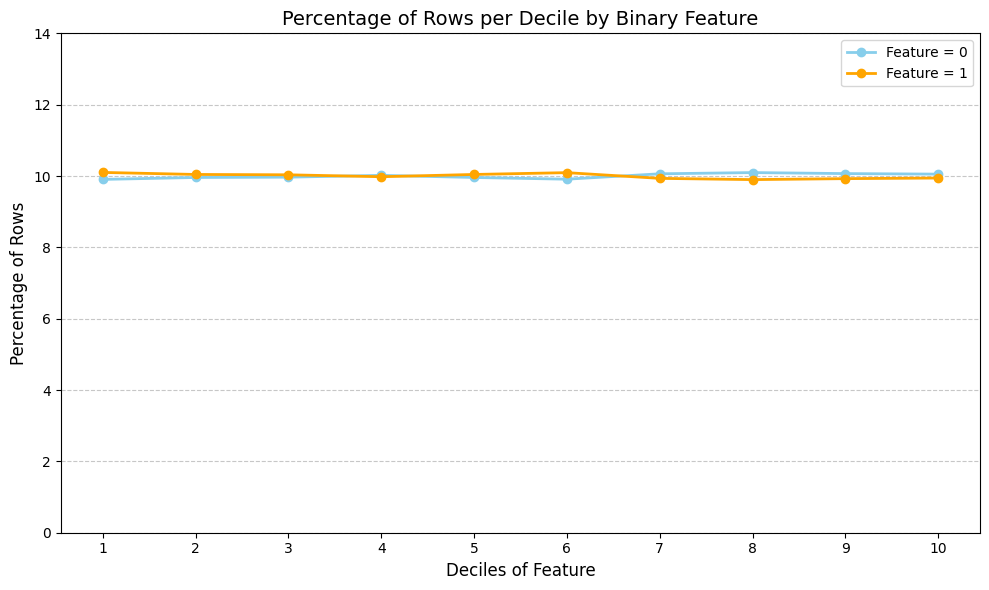

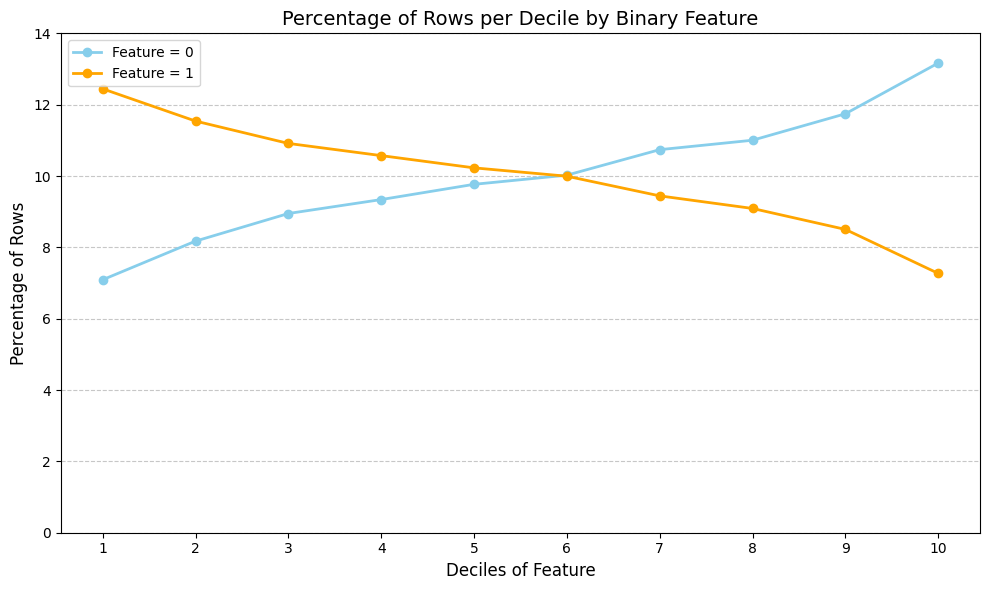

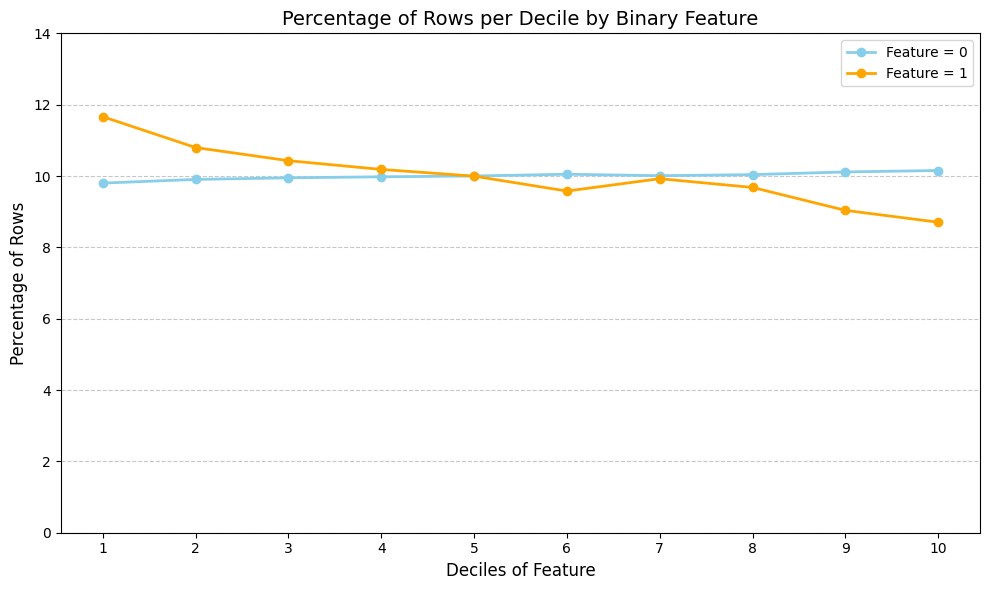

In [7]:
percentage_per_decile('persoon_geslacht_vrouw', test_data)
percentage_per_decile('persoonlijke_eigenschappen_taaleis_voldaan', test_data)
percentage_per_decile('adres_recentste_wijk_charlois', test_data)


In [ ]:
#controlled statistical parity for the different districts
def controlled_statistical_parity_districts(test_data, session):
    district_column_names = np.array([s for s in list(test_data.columns.values) if s.startswith('adres_recentste_wijk_')])
    district_full_names = np.array(['Charlois', 'Delfshaven', 'Feijenoord', 'Ijsselmonde', 'Kralingen-Crooswijk',
                       'Noord', 'Other', 'Prins Alexander', 'Stadscentrum'])
    
    data_list = []
    for district in district_column_names:
        df_temp = test_data.copy()
        df_temp[district] = 1
        for other_district in district_column_names:
            if other_district != district:
                df_temp[other_district] = 0
        data_list.append(df_temp)
        
    for i, d in enumerate(data_list):
        X = d.drop(['checked'], axis=1)
        y_pred_onnx =  session.run(None, {'X': X.values.astype(np.float32)})
        parity = y_pred_onnx[1].sum() / len(y_pred_onnx[1]) #number of high-risk divided by total group size
        print(f'Parity ({district_full_names[i]}): {parity}')

    print('')

In [21]:
controlled_statistical_parity_districts(test_data, new_session)

Parity (Charlois): 0.15082307692307692
Parity (Delfshaven): 0.15082307692307692
Parity (Feijenoord): 0.15082307692307692
Parity (Ijsselmonde): 0.15082307692307692
Parity (Kralingen-Crooswijk): 0.15082307692307692
Parity (Noord): 0.15082307692307692
Parity (Other): 0.15082307692307692
Parity (Prins Alexander): 0.18993076923076924
Parity (Stadscentrum): 0.15082307692307692

